# **Step 1: Load the Dataset**

In [55]:
# Step 1: Import essential libraries
import pandas as pd

# Step 2: Load the dataset
file_path = '/content/online_retail_II.csv'  # adjust if needed

# Step 3: Read CSV file with dtype warning handling
df = pd.read_csv(file_path, low_memory=False)

# Step 4: Show basic structure
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [57]:
# Basic info
df.info()

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:\n", missing_values)

# Check number of unique countries
print("\nUnique countries:", df['Country'].nunique())
print(df['Country'].value_counts().head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB

Missing values per column:
 Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Unique countries: 43
Country
United Kingdom    981330
EIRE               17866
Germany            17624
France             14330
Netherlands         5140
Name: count,

# **Step 2: Data Cleaning (Preprocessing)**

In [58]:
# Step 1: Remove cancelled transactions (Invoice starts with 'C')
df_clean = df[~df['Invoice'].astype(str).str.startswith('C')]

# Step 2: Drop rows with missing Customer ID or Description
df_clean = df_clean.dropna(subset=['Customer ID', 'Description'])

# Step 3: Remove duplicates
df_clean = df_clean.drop_duplicates()

# Step 4: Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Step 5: Reset index
df_clean.reset_index(drop=True, inplace=True)

# Final cleaned shape
print("Cleaned dataset shape:", df_clean.shape)

# Optional: check again for missing values
print("\nRemaining missing values:\n", df_clean.isnull().sum())


Cleaned dataset shape: (779495, 8)

Remaining missing values:
 Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


In [59]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779495 non-null  object        
 1   StockCode    779495 non-null  object        
 2   Description  779495 non-null  object        
 3   Quantity     779495 non-null  int64         
 4   InvoiceDate  779495 non-null  datetime64[ns]
 5   Price        779495 non-null  float64       
 6   Customer ID  779495 non-null  float64       
 7   Country      779495 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 47.6+ MB


In [60]:
df_clean.shape

(779495, 8)

In [61]:
# 1. Create TotalPrice
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']

# 2. Create date-based features
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour
df_clean['Weekday'] = df_clean['InvoiceDate'].dt.dayofweek

# 3. RFM Analysis Preparation (Customer level aggregation)
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview the engineered dataset
print(df_clean[['TotalPrice', 'Year', 'Month', 'Day', 'Hour', 'Weekday']].head())
print("\nRFM sample:\n", rfm.head())


   TotalPrice  Year  Month  Day  Hour  Weekday
0        83.4  2009     12    1     7        1
1        81.0  2009     12    1     7        1
2        81.0  2009     12    1     7        1
3       100.8  2009     12    1     7        1
4        30.0  2009     12    1     7        1

RFM sample:
    CustomerID  Recency  Frequency  Monetary
0     12346.0      326         12  77556.46
1     12347.0        2          8   4921.53
2     12348.0       75          5   2019.40
3     12349.0       19          4   4428.69
4     12350.0      310          1    334.40


# **Step 4: Exploratory Data Analysis (EDA)**

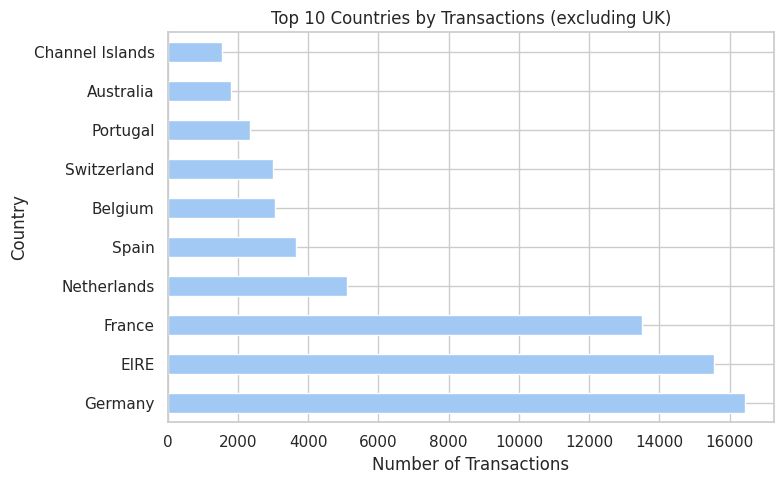

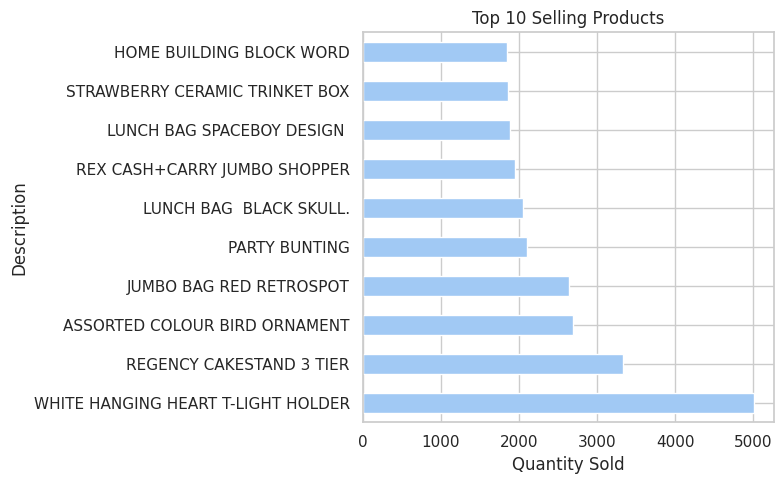

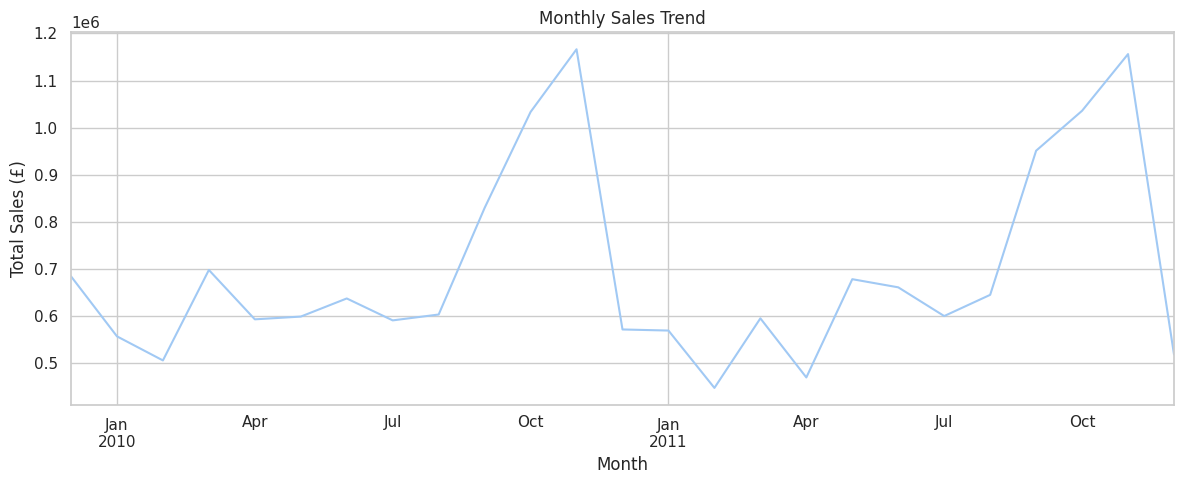

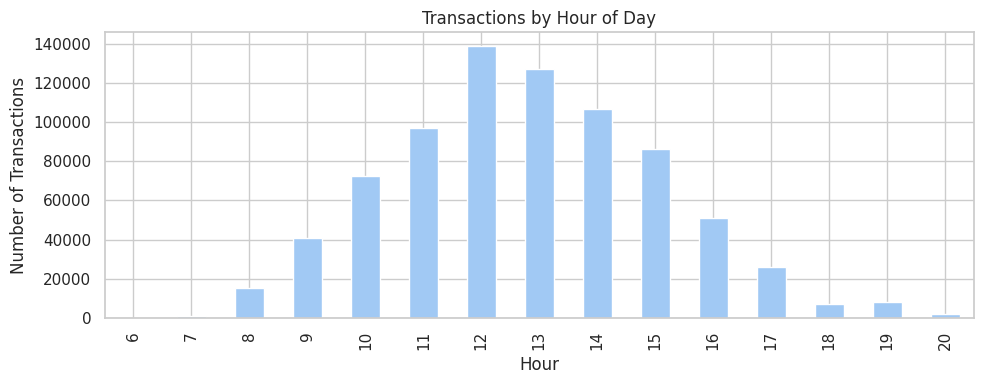

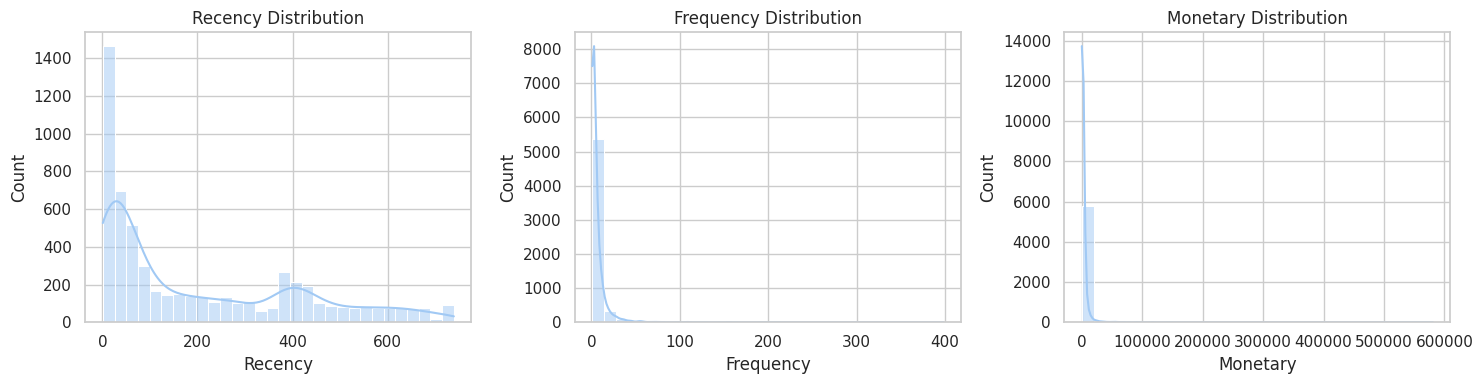

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn's styling directly
sns.set(style="whitegrid", palette="pastel")

# 1. Top 10 countries (excluding UK)
top_countries = df_clean[df_clean['Country'] != 'United Kingdom']['Country'].value_counts().head(10)
top_countries.plot(kind='barh', figsize=(8, 5), title='Top 10 Countries by Transactions (excluding UK)')
plt.xlabel('Number of Transactions')
plt.tight_layout()
plt.show()

# 2. Top 10 selling products
top_products = df_clean['Description'].value_counts().head(10)
top_products.plot(kind='barh', figsize=(8, 5), title='Top 10 Selling Products')
plt.xlabel('Quantity Sold')
plt.tight_layout()
plt.show()

# 3. Monthly sales trend
monthly_sales = df_clean.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()
monthly_sales.plot(figsize=(12, 5), title='Monthly Sales Trend')
plt.ylabel('Total Sales (£)')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

# 4. Hourly purchase pattern
hourly_sales = df_clean.groupby('Hour')['Invoice'].count()
hourly_sales.plot(kind='bar', figsize=(10, 4), title='Transactions by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

# 5. RFM Histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(rfm['Recency'], bins=30, ax=axs[0], kde=True)
axs[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=30, ax=axs[1], kde=True)
axs[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=30, ax=axs[2], kde=True)
axs[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()


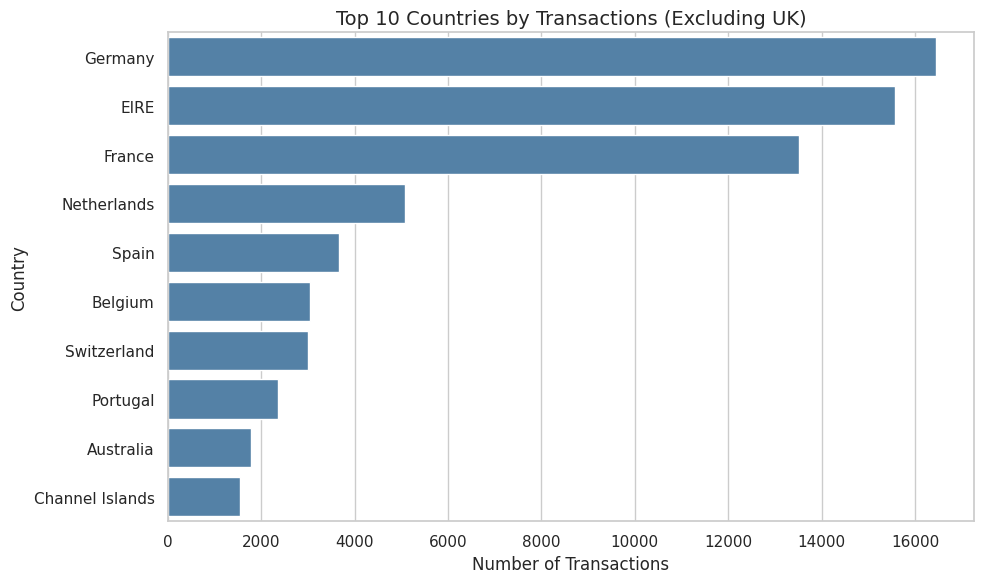

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot styling
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Prepare data as DataFrame for safe barplot usage
top_countries = df_clean[df_clean['Country'] != 'United Kingdom']['Country'].value_counts().head(10)
top_countries_df = pd.DataFrame({
    'Country': top_countries.index,
    'Transactions': top_countries.values
})

# Use solid and vibrant color palette
sns.barplot(data=top_countries_df, x='Transactions', y='Country', color='steelblue')

# Title without emoji, solid blue bar
plt.title('Top 10 Countries by Transactions (Excluding UK)', fontsize=14)
plt.xlabel('Number of Transactions')
plt.ylabel('Country')

plt.tight_layout()
plt.show()


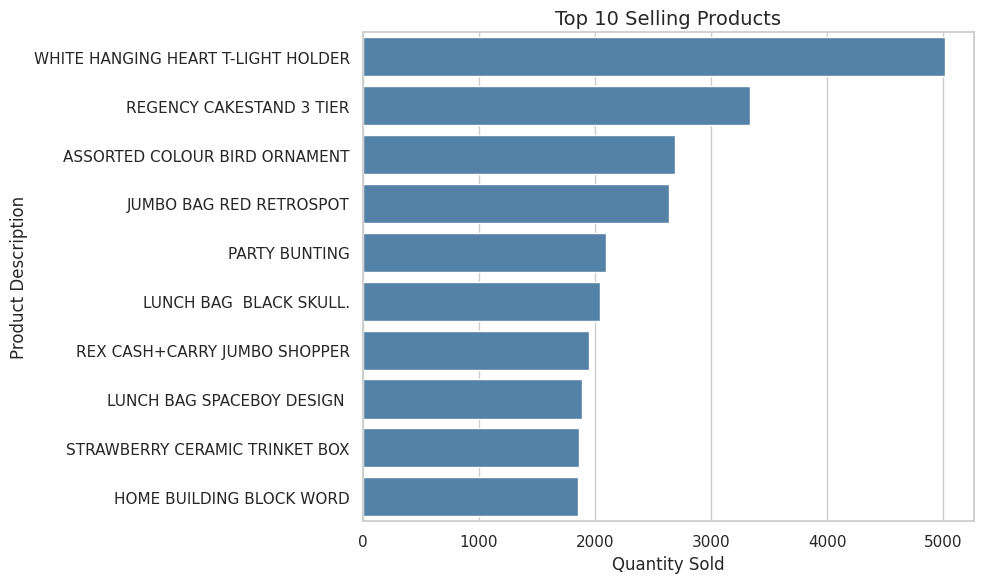

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Prepare the top product data
top_products = df_clean['Description'].value_counts().head(10)
top_products_df = pd.DataFrame({
    'Product': top_products.index,
    'Quantity': top_products.values
})

# Use a solid color (e.g., 'steelblue') instead of a palette to avoid warnings and fading
sns.barplot(data=top_products_df, x='Quantity', y='Product', color='steelblue')

# Add labels and title
plt.title('Top 10 Selling Products', fontsize=14)
plt.xlabel('Quantity Sold')
plt.ylabel('Product Description')

plt.tight_layout()
plt.show()


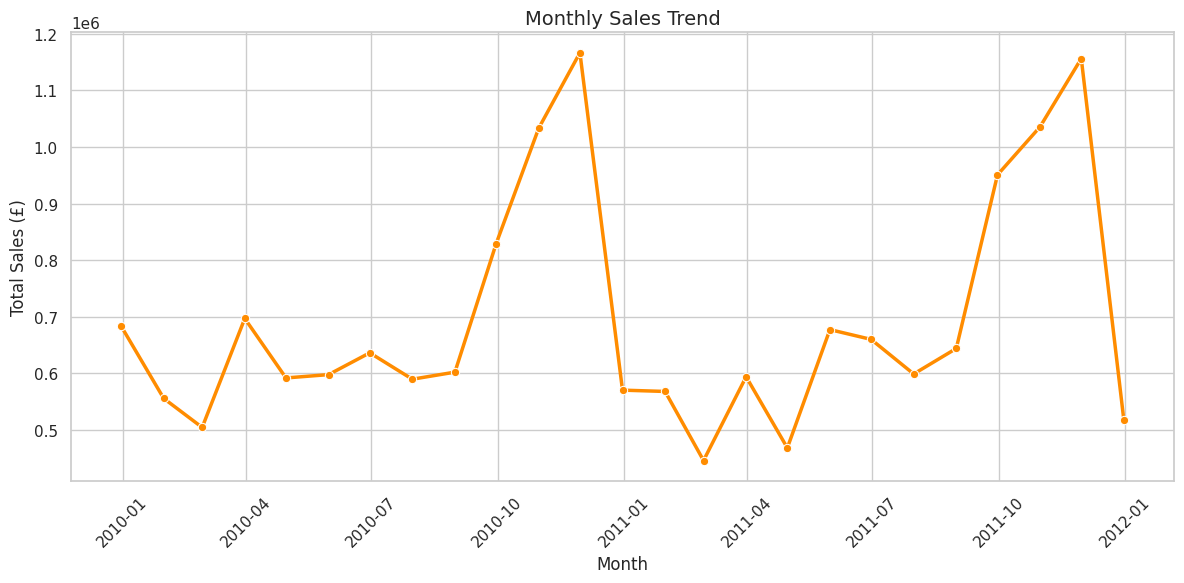

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure datetime type
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Resample using 'ME' instead of deprecated 'M'
monthly_sales = df_clean.set_index('InvoiceDate').resample('ME')['TotalPrice'].sum()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, color='darkorange', marker='o', linewidth=2.5)

# Title and labels
plt.title('Monthly Sales Trend', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


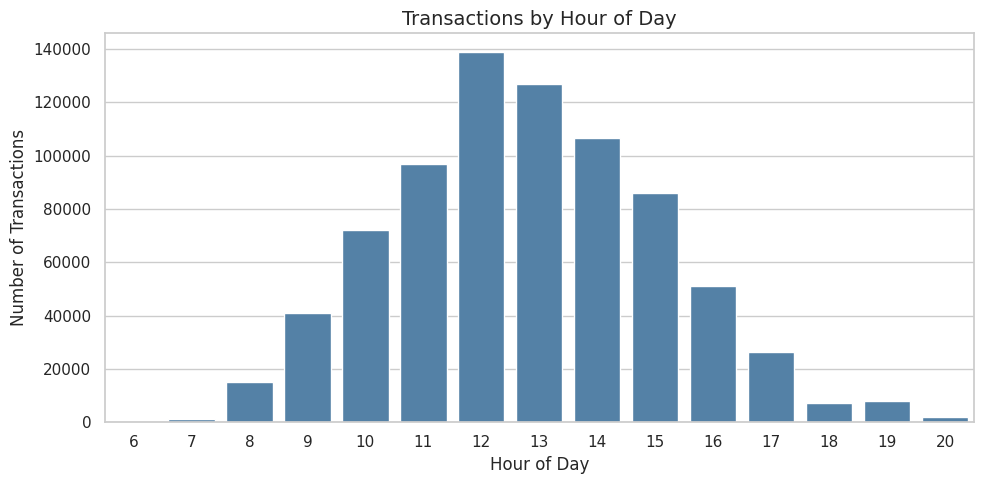

In [66]:
plt.figure(figsize=(10, 5))

hourly_sales = df_clean.groupby('Hour')['Invoice'].count()
sns.barplot(x=hourly_sales.index, y=hourly_sales.values, color='steelblue')

plt.title('Transactions by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()


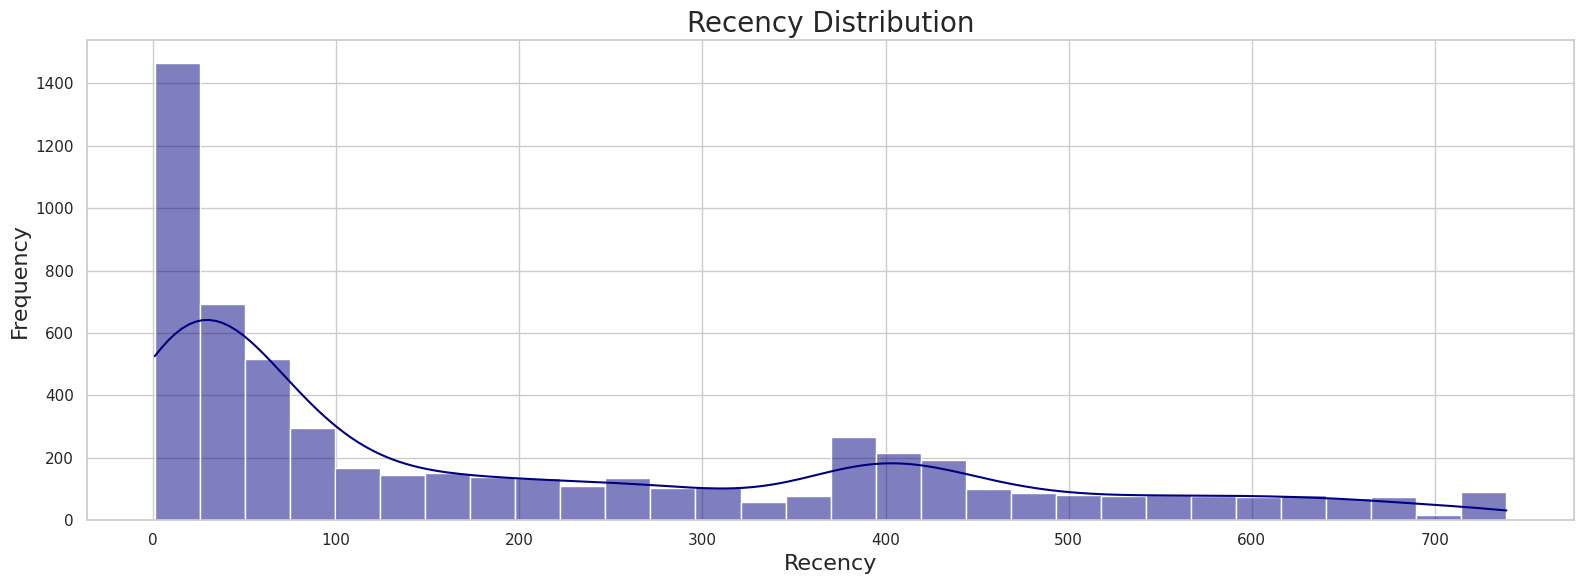

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --- Recency ---
plt.figure(figsize=(16, 6))
sns.histplot(rfm['Recency'], bins=30, color='navy', kde=True)
plt.title('Recency Distribution', fontsize=20)
plt.xlabel('Recency', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tight_layout()
plt.show()



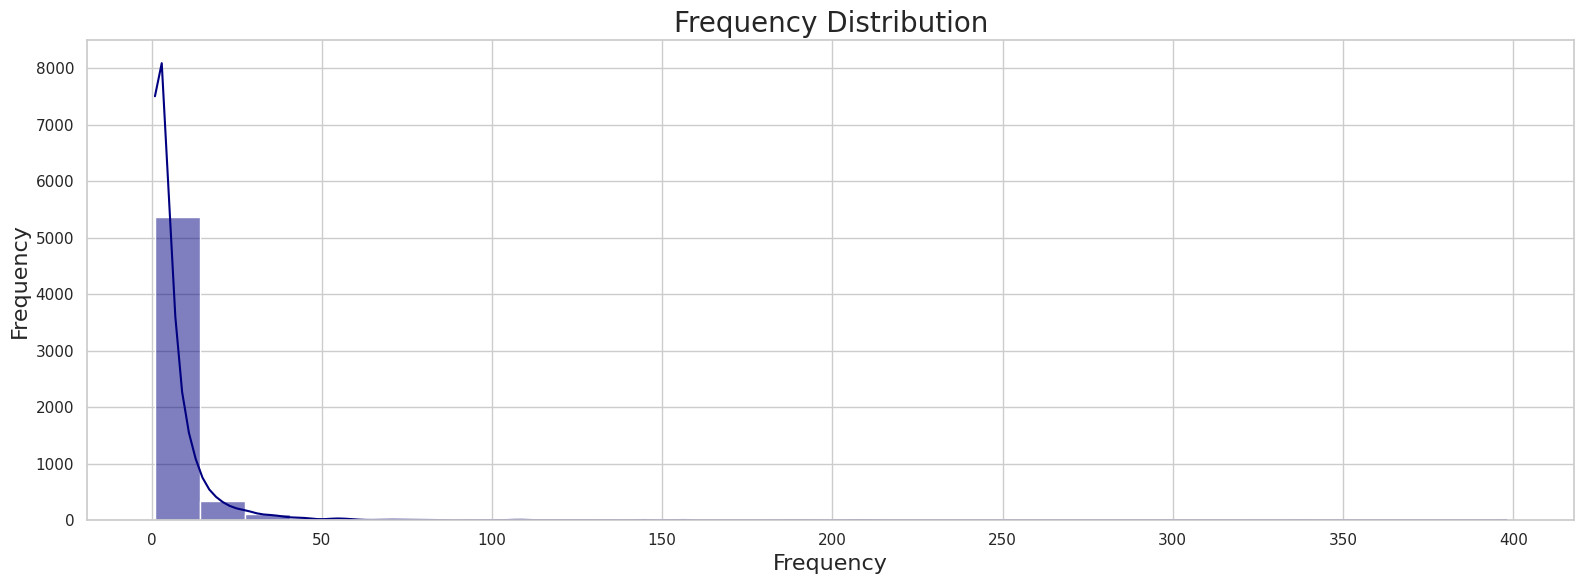

In [68]:
# --- Frequency ---
plt.figure(figsize=(16, 6))
sns.histplot(rfm['Frequency'], bins=30, color='navy', kde=True)
plt.title('Frequency Distribution', fontsize=20)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tight_layout()
plt.show()


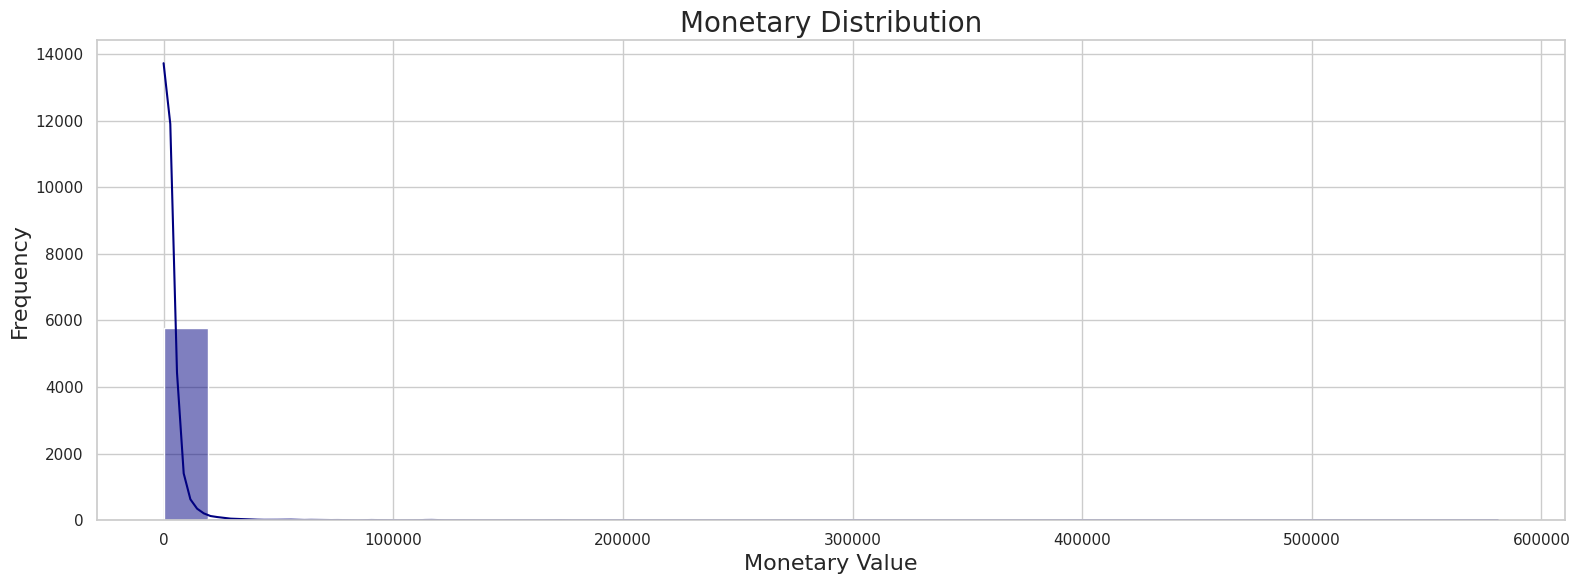

In [69]:
# --- Monetary ---
plt.figure(figsize=(16, 6))
sns.histplot(rfm['Monetary'], bins=30, color='navy', kde=True)
plt.title('Monetary Distribution', fontsize=20)
plt.xlabel('Monetary Value', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tight_layout()
plt.show()

In [70]:
from sklearn.preprocessing import StandardScaler

# Keep a copy for reference
rfm_original = rfm.copy()

# Normalize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


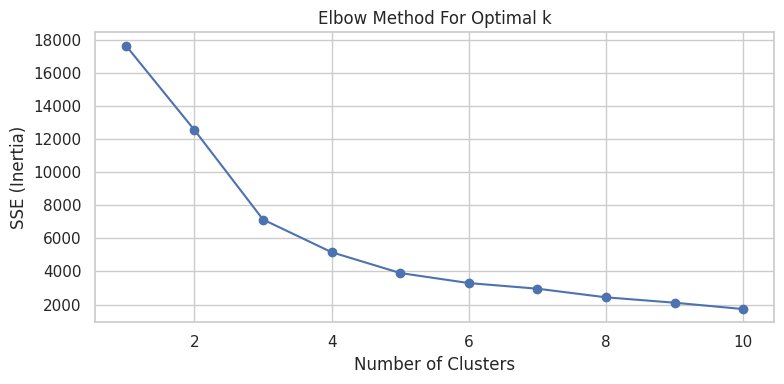

In [71]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method For Optimal k")
plt.tight_layout()
plt.show()


In [72]:
# Let’s say 3 clusters based on elbow method
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [73]:
# View mean RFM values for each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).round(2)

print(cluster_summary)


         Recency  Frequency   Monetary  Count
Cluster                                      
0          66.33       7.64    3134.79   3849
1         462.16       2.20     746.41   2010
2          23.09     143.14  173123.58     22


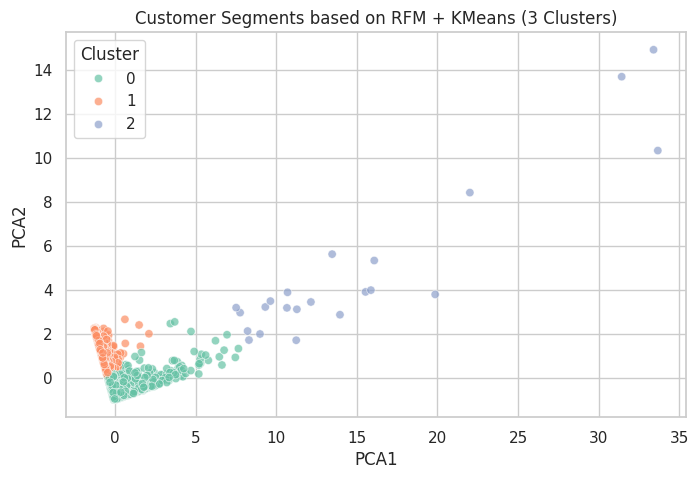

In [74]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=3)
rfm_pca = pca.fit_transform(rfm_scaled)

# Add to dataframe for plotting
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', alpha=0.7)
plt.title('Customer Segments based on RFM + KMeans (3 Clusters)')
plt.show()


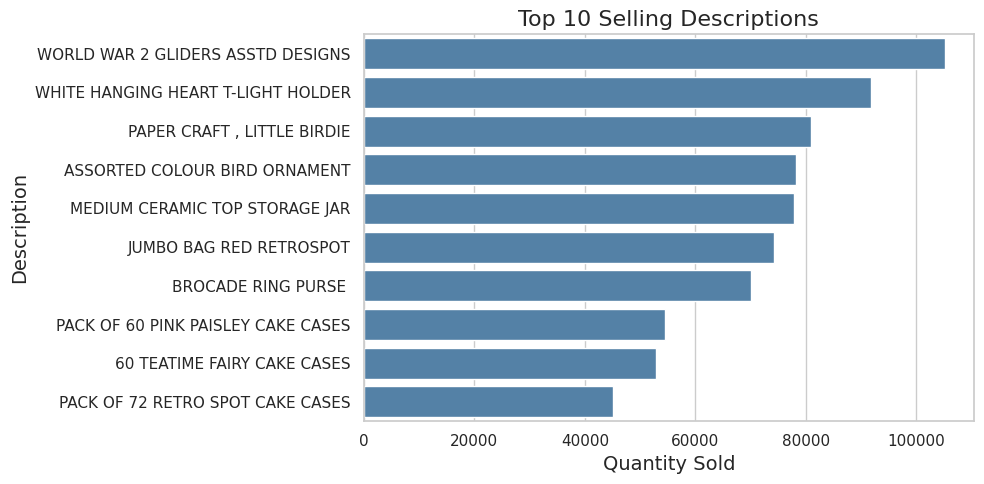

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the function to generate the top 10 plot
def top_10_fig(data, description_column, quantity_column):
    # Get top 10 products by quantity sold
    top_10 = data.groupby(description_column)[quantity_column].sum().sort_values(ascending=False).head(10)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_10.values, y=top_10.index, color='steelblue')

    plt.title(f'Top 10 Selling {description_column.capitalize()}s', fontsize=16)
    plt.xlabel('Quantity Sold', fontsize=14)
    plt.ylabel(description_column.capitalize(), fontsize=14)
    plt.tight_layout()
    plt.show()

# Now call the function
top_10_fig(df_clean, 'Description', 'Quantity')


# Association rule mining

In [76]:
# Required imports
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import matplotlib.pyplot as plt

Top 5 Association Rules (France):
                                             antecedents  \
31768  (ALARM CLOCK BAKELIKE PINK, SET/6 RED SPOTTY P...   
9697                          (SET/6 COLLAGE PAPER CUPS)   
31769  (ALARM CLOCK BAKELIKE GREEN, SET/6 RED SPOTTY ...   
9696                        (SET/6 COLLAGE PAPER PLATES)   
31766  (ALARM CLOCK BAKELIKE PINK, SET/6 RED SPOTTY P...   

                                             consequents   support  \
31768  (ALARM CLOCK BAKELIKE GREEN, SET/6 RED SPOTTY ...  0.010724   
9697                        (SET/6 COLLAGE PAPER PLATES)  0.012064   
31769  (ALARM CLOCK BAKELIKE PINK, SET/6 RED SPOTTY P...  0.010724   
9696                          (SET/6 COLLAGE PAPER CUPS)  0.012064   
31766  (ALARM CLOCK BAKELIKE GREEN, SET/6 RED SPOTTY ...  0.010724   

       confidence       lift  
31768    0.800000  74.600000  
9697     1.000000  74.600000  
31769    1.000000  74.600000  
9696     0.900000  74.600000  
31766    0.888889  73.679012 

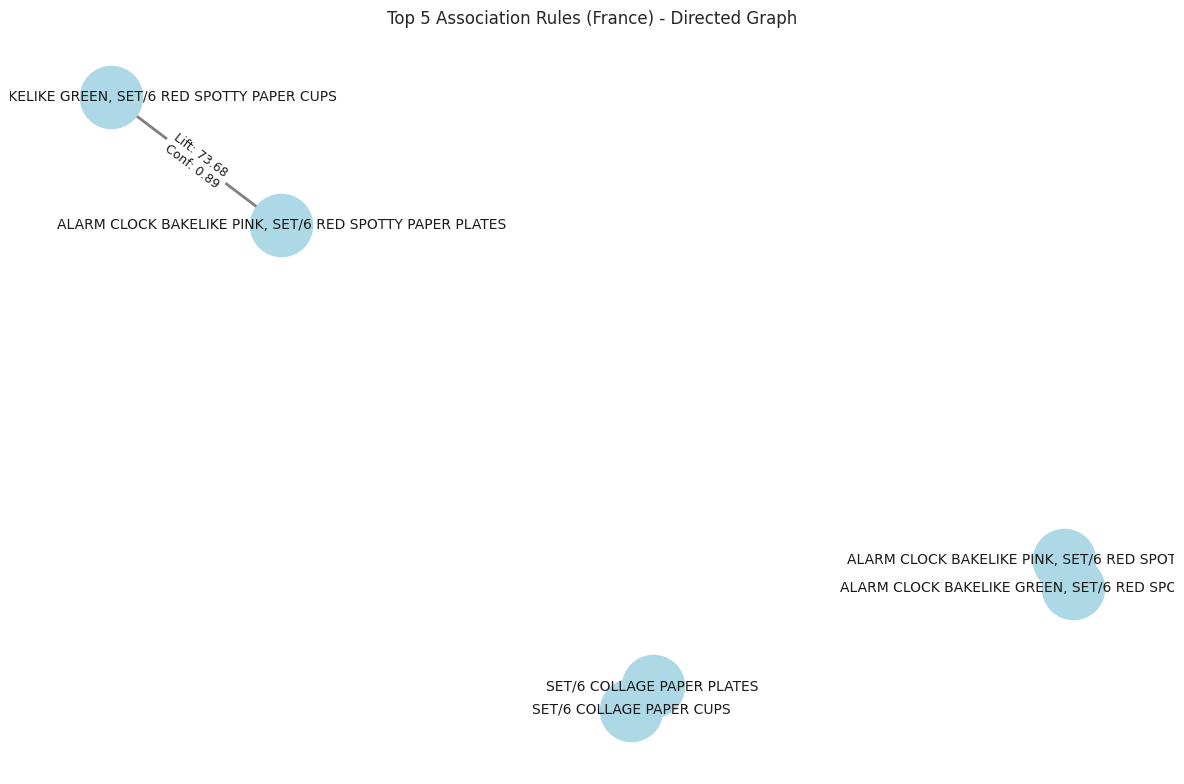

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Filter for one country (e.g., France)
df_france = df[df['Country'] == 'France']

# Group by Invoice and list products per transaction
basket_france = df_france.groupby(['Invoice'])['Description'].apply(list)

# Convert to list of transactions
transactions = basket_france.tolist()

# Apply Transaction Encoder
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply FP-Growth
frequent_itemsets = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Filter strong rules
rules_filtered = rules[(rules['lift'] > 1.2) & (rules['confidence'] > 0.5)]

# Sort by lift for top rules
top_rules = rules_filtered.sort_values(by='lift', ascending=False).head(5)

# Display top rules
print("Top 5 Association Rules (France):")
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# --- Network Graph for Top Rules ---
# Convert frozenset to string for visualization
def format_set(s):
    return ', '.join(list(s))

top_rules['antecedents_str'] = top_rules['antecedents'].apply(format_set)
top_rules['consequents_str'] = top_rules['consequents'].apply(format_set)

# Create directed graph
G = nx.DiGraph()

for _, row in top_rules.iterrows():
    G.add_edge(row['antecedents_str'], row['consequents_str'],
               weight=row['lift'], label=f"Lift: {row['lift']:.2f}\nConf: {row['confidence']:.2f}")

# Draw the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')

# Draw edges
edges = G.edges(data=True)
edge_labels = {(u, v): d['label'] for u, v, d in edges}
edge_weights = [d['weight'] for _, _, d in edges]
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, arrows=True, edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Top 5 Association Rules (France) - Directed Graph")
plt.axis('off')
plt.tight_layout()
plt.show()


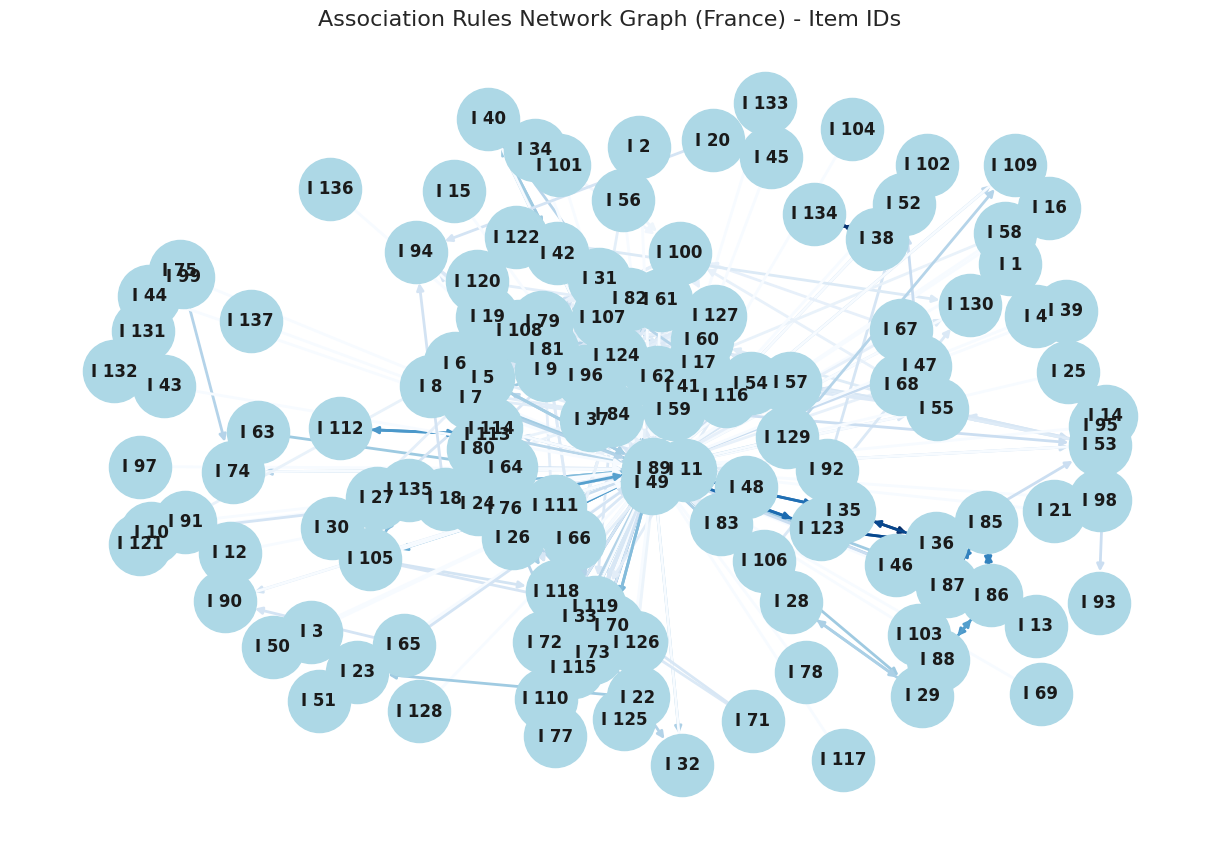


Item ID Mapping:
I 1:  RED/WHITE DOT MINI CASES
I 2: 10 COLOUR SPACEBOY PEN
I 3: 12 PENCIL SMALL TUBE WOODLAND
I 4: 3 PIECE SPACEBOY COOKIE CUTTER SET
I 5: ALARM CLOCK BAKELIKE GREEN
I 6: ALARM CLOCK BAKELIKE ORANGE
I 7: ALARM CLOCK BAKELIKE PINK
I 8: ALARM CLOCK BAKELIKE RED 
I 9: ASSORTED COLOUR MINI CASES
I 10: BAKING SET 9 PIECE RETROSPOT 
I 11: BAKING SET SPACEBOY DESIGN
I 12: BLACK RECORD COVER FRAME
I 13: BLUE  SPOTTY CUP
I 14: BLUE HARMONICA IN BOX 
I 15: BLUE POLKADOT CUP
I 16: CAKE STAND WHITE TWO TIER LACE
I 17: CARD DOLLY GIRL 
I 18: CHARLOTTE BAG APPLES DESIGN
I 19: CHARLOTTE BAG DOLLY GIRL DESIGN
I 20: CHARLOTTE BAG PINK POLKADOT
I 21: CHARLOTTE BAG SUKI DESIGN
I 22: CHILDREN'S APRON DOLLY GIRL 
I 23: CHILDRENS APRON SPACEBOY DESIGN
I 24: CHILDRENS CUTLERY DOLLY GIRL 
I 25: CHILDRENS CUTLERY POLKADOT PINK
I 26: CHILDRENS CUTLERY SPACEBOY 
I 27: CHILDS BREAKFAST SET CIRCUS PARADE
I 28: CHILDS BREAKFAST SET DOLLY GIRL 
I 29: CHILDS BREAKFAST SET SPACEBOY 
I 30: CIRCUS PARA

In [78]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import networkx as nx

# 1. Prepare data for France
basket = (df_clean[df_clean['Country'] == 'France']
          .groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().fillna(0))

# 2. Convert to boolean (True = product present, False = absent)
basket = basket > 0

# 3. Apply FP-Growth
frequent_itemsets = fpgrowth(basket, min_support=0.02, use_colnames=True)

# 4. Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 5. Filter strong rules
strong_rules = rules[(rules['lift'] > 1.2) & (rules['confidence'] > 0.5)]

# 6. Create node-label mapping
items = set()
for _, row in strong_rules.iterrows():
    items.update(row['antecedents'])
    items.update(row['consequents'])

item_to_id = {item: f'I {i+1}' for i, item in enumerate(sorted(items))}
id_to_item = {v: k for k, v in item_to_id.items()}  # Reverse mapping for reference

# 7. Build graph with numeric labels
plt.figure(figsize=(12, 8))
G = nx.DiGraph()

for _, row in strong_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(item_to_id[antecedent], item_to_id[consequent], weight=row['lift'])

# Draw
pos = nx.spring_layout(G, k=0.5, iterations=20)
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue',
        font_size=12, font_weight='bold', edge_color=weights, width=2.0, edge_cmap=plt.cm.Blues)

plt.title("Association Rules Network Graph (France) - Item IDs", fontsize=16)
#plt.tight_layout()
plt.show()

# Optional: Print mapping for interpretation
print("\nItem ID Mapping:")
for item, label in item_to_id.items():
    print(f"{label}: {item}")


# Classification

In [79]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt


In [80]:
# Join original df_clean with RFM to include Country
rfm_with_country = df_clean[['Customer ID', 'Country']].drop_duplicates()
rfm_full = rfm.merge(rfm_with_country, left_on='CustomerID', right_on='Customer ID', how='left').drop(columns=['Customer ID'])

# Label target variable
threshold = rfm_full['Monetary'].quantile(0.75)
rfm_full['HighValueCustomer'] = (rfm_full['Monetary'] >= threshold).astype(int)

# One-hot encode Country
rfm_encoded = pd.get_dummies(rfm_full, columns=['Country'], drop_first=True)

# Define features and target
features = [col for col in rfm_encoded.columns if col not in ['HighValueCustomer', 'CustomerID']]
X = rfm_encoded[features]
y = rfm_encoded['HighValueCustomer']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [81]:
# Modified evaluation function that returns metrics
def evaluate_with_roc_return(name, model, X_train, X_test, y_train, y_test, scaled=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    return {
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }


In [82]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def evaluate_with_roc(name, model, X_train, X_test, y_train, y_test, scaled=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n--- {name} ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()



--- Naive Bayes ---
Accuracy:  0.2731
Precision: 0.2614
Recall:    0.9967
F1 Score:  0.4142
ROC AUC:   0.6968


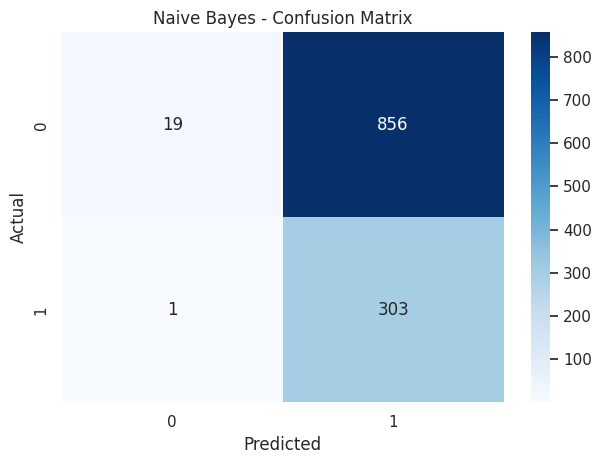

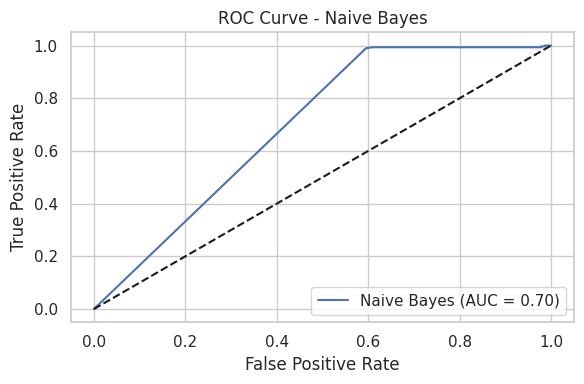

In [83]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
evaluate_with_roc("Naive Bayes", GaussianNB(),
                  X_train_scaled, X_test_scaled, y_train, y_test)


--- K-Nearest Neighbors ---
Accuracy:  0.9627
Precision: 0.9676
Recall:    0.8849
F1 Score:  0.9244
ROC AUC:   0.9856


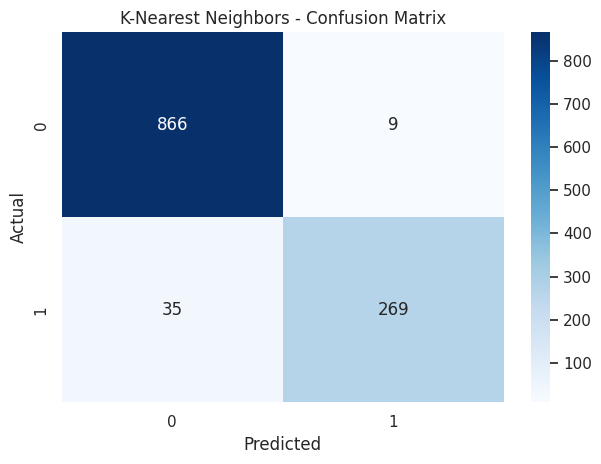

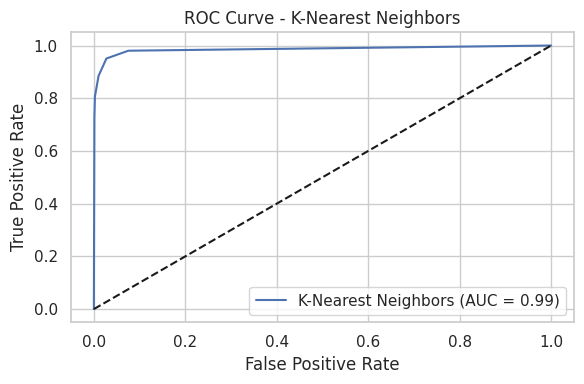

In [84]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
evaluate_with_roc("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5),
                  X_train_scaled, X_test_scaled, y_train, y_test)



--- Support Vector Machine ---
Accuracy:  0.9186
Precision: 0.9444
Recall:    0.7270
F1 Score:  0.8216
ROC AUC:   0.9820


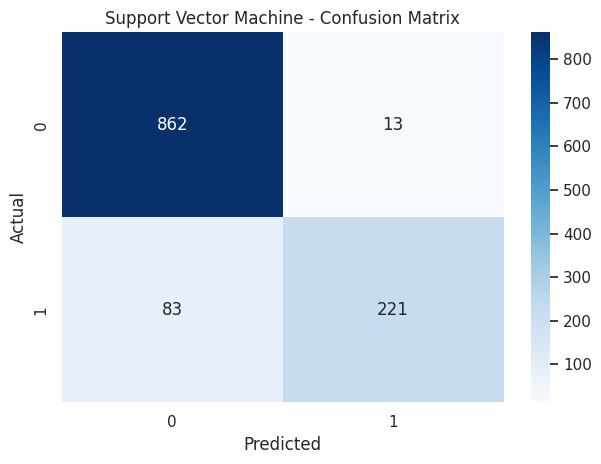

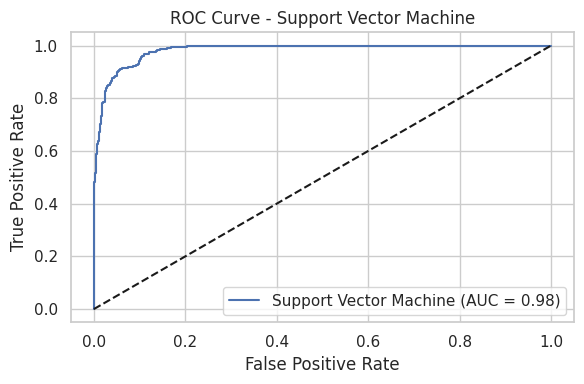

In [85]:
# Support Vector Machine
from sklearn.svm import SVC
evaluate_with_roc("Support Vector Machine", SVC(kernel='rbf', probability=True, random_state=42),
                  X_train_scaled, X_test_scaled, y_train, y_test)


# Clustering & Segmentation

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

In [87]:
# --- Compute RFM features ---
df['TotalPrice'] = df['Price'] * df['Quantity']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Drop missing and outliers
rfm.dropna(inplace=True)
rfm = rfm[rfm['Monetary'] > 0]

# --- Standardize RFM ---
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

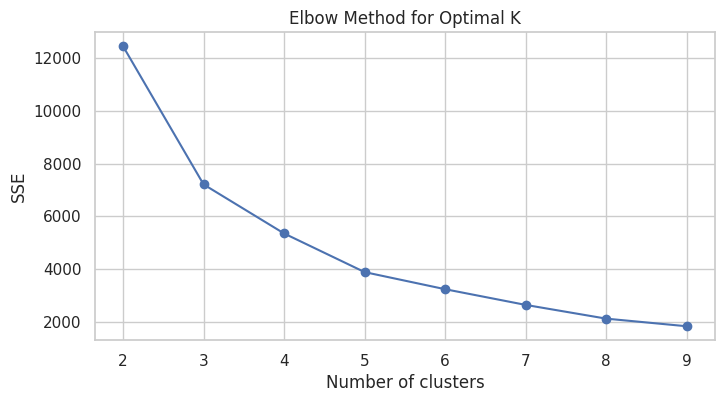

In [88]:
# ------------------------------------
# 1️⃣ K-MEANS CLUSTERING
# ------------------------------------
# Find optimal number of clusters using Elbow method
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid(True)
plt.show()


In [89]:
# Apply KMeans with chosen K
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

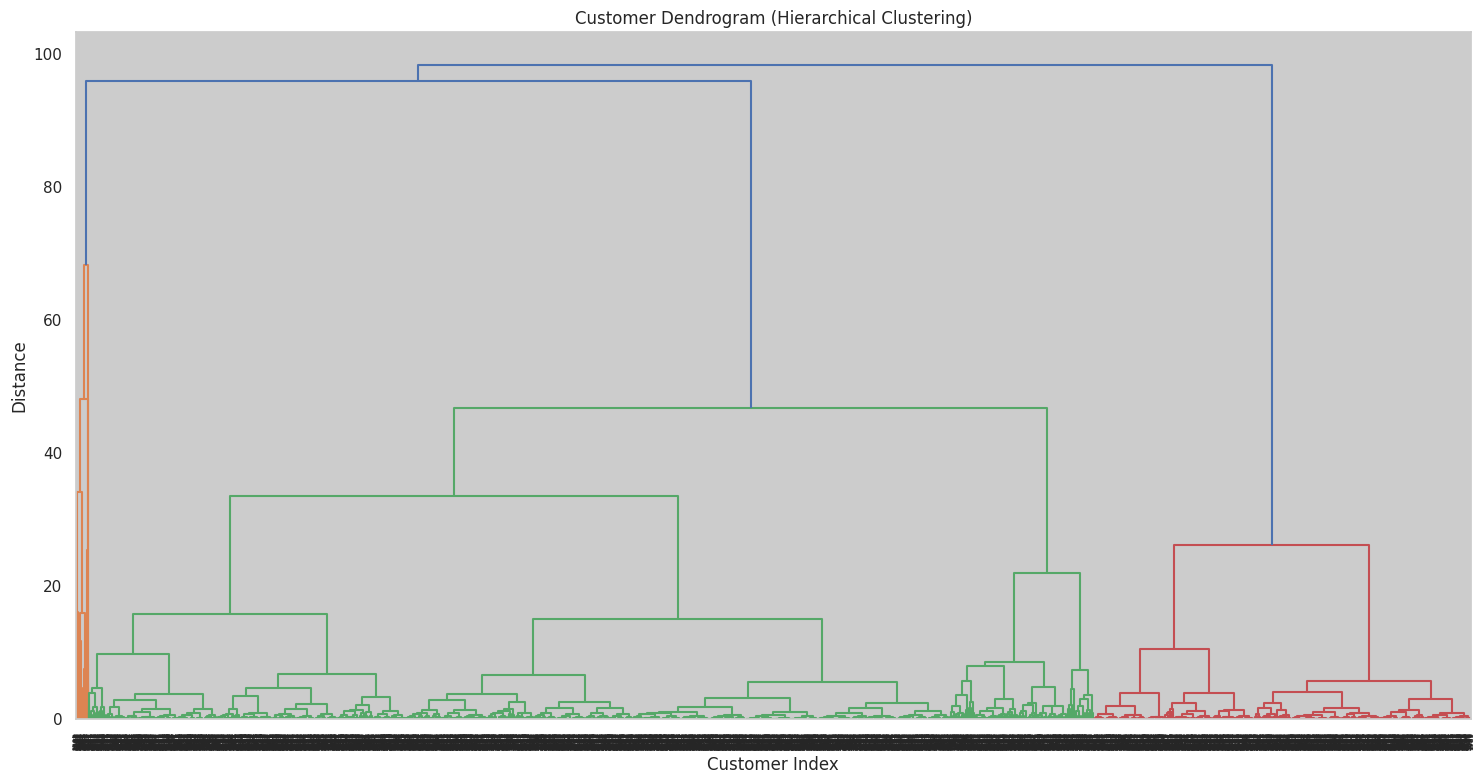

In [90]:
# ------------------------------------
# 2️⃣ HIERARCHICAL CLUSTERING
# ------------------------------------
linked = linkage(rfm_scaled, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Customer Dendrogram (Hierarchical Clustering)')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Apply Agglomerative clustering
hc = AgglomerativeClustering(n_clusters=3)
rfm['Hierarchical_Cluster'] = hc.fit_predict(rfm_scaled)



In [91]:
# ------------------------------------
# 3️⃣ DBSCAN (Density-Based)
# ------------------------------------
db = DBSCAN(eps=1.5, min_samples=5)
rfm['DBSCAN_Cluster'] = db.fit_predict(rfm_scaled)

# Count noise points
noise_count = sum(rfm['DBSCAN_Cluster'] == -1)
print(f"DBSCAN noise points (outliers): {noise_count}")


DBSCAN noise points (outliers): 25


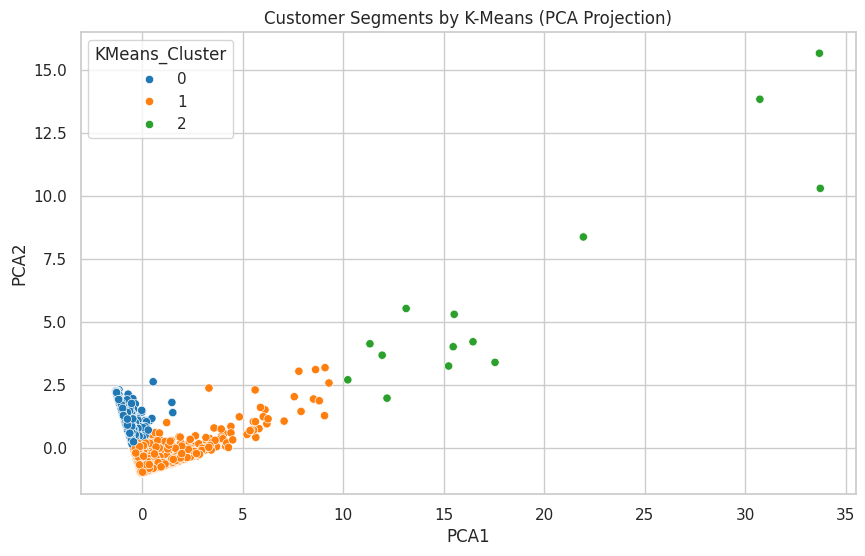

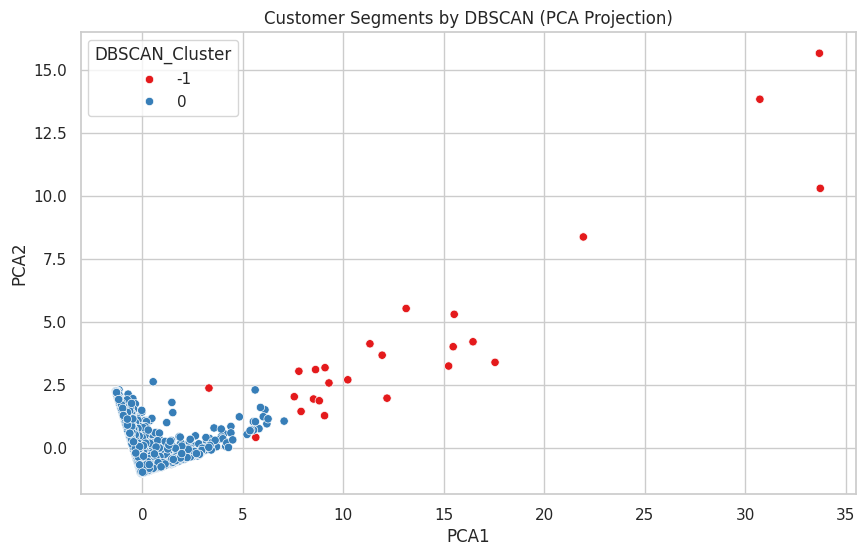

In [92]:
# ------------------------------------
# 4️⃣ PCA FOR VISUALIZATION
# ------------------------------------
pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = components[:, 0]
rfm['PCA2'] = components[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='tab10')
plt.title('Customer Segments by K-Means (PCA Projection)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set1')
plt.title('Customer Segments by DBSCAN (PCA Projection)')
plt.show()

In [93]:
# ------------------------------------
# 5️⃣ CLUSTER INTERPRETATION
# ------------------------------------
cluster_summary = rfm.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)
print("K-Means Cluster Interpretation (RFM means):")
print(cluster_summary)

# Optional: Label clusters manually
def interpret_cluster(row):
    if row['KMeans_Cluster'] == 0:
        return 'High-Value Loyal'
    elif row['KMeans_Cluster'] == 1:
        return 'Low-Spend Recent'
    elif row['KMeans_Cluster'] == 2:
        return 'Churned'
    elif row['KMeans_Cluster'] == 3:
        return 'Frequent Low-Value'
    else:
        return 'Other'

rfm['Segment'] = rfm.apply(interpret_cluster, axis=1)

K-Means Cluster Interpretation (RFM means):
                Recency  Frequency  Monetary
KMeans_Cluster                              
0                 458.5        2.6     698.7
1                  64.5        9.5    3234.2
2                   3.0      217.5  206875.5


In [94]:
!pip install prophet


# Step 7: Time Series Analysis

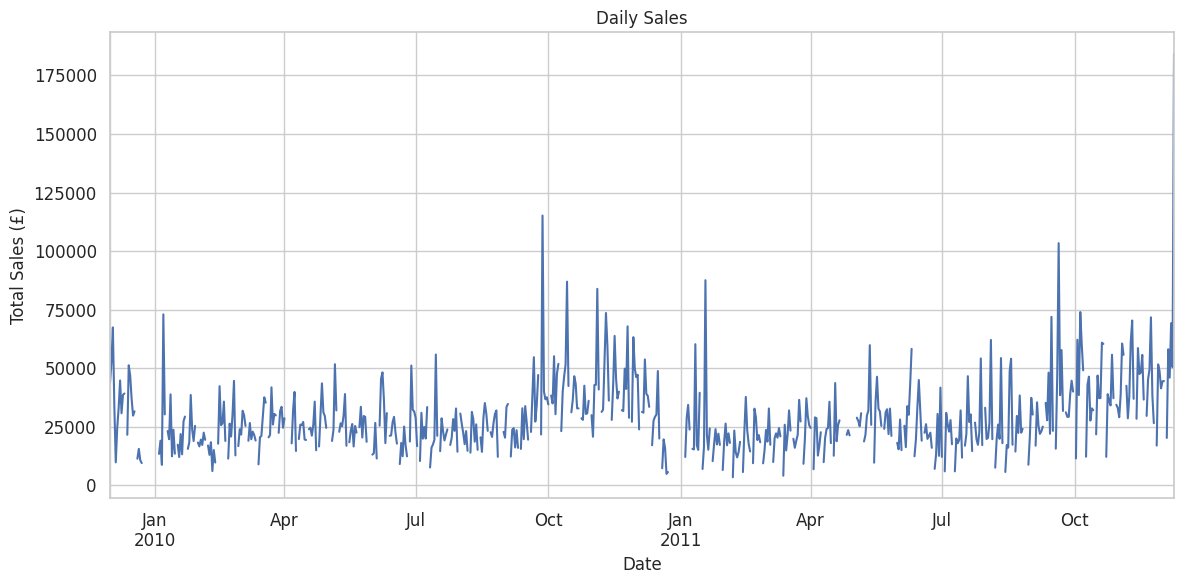

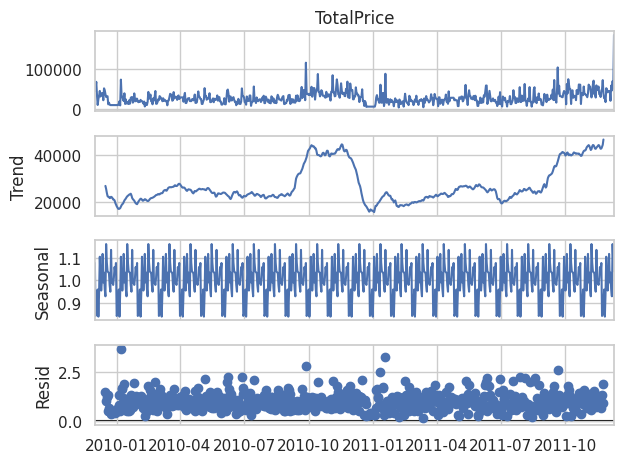

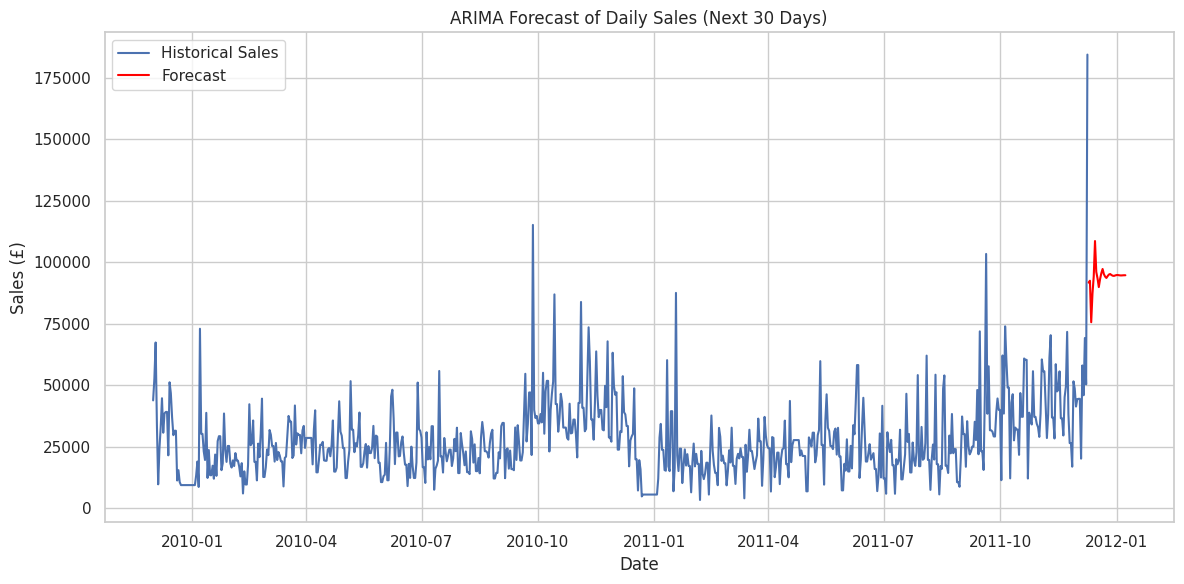

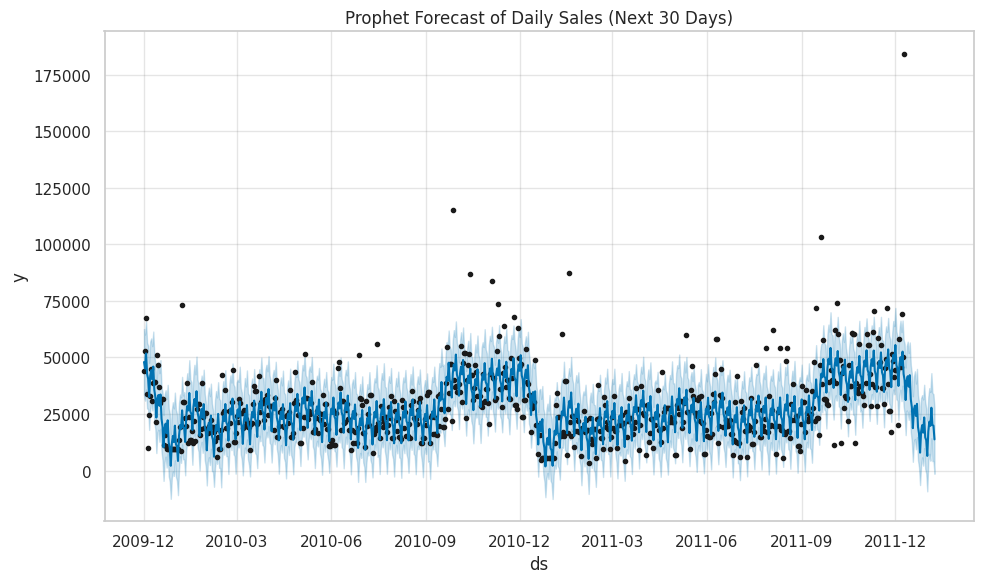

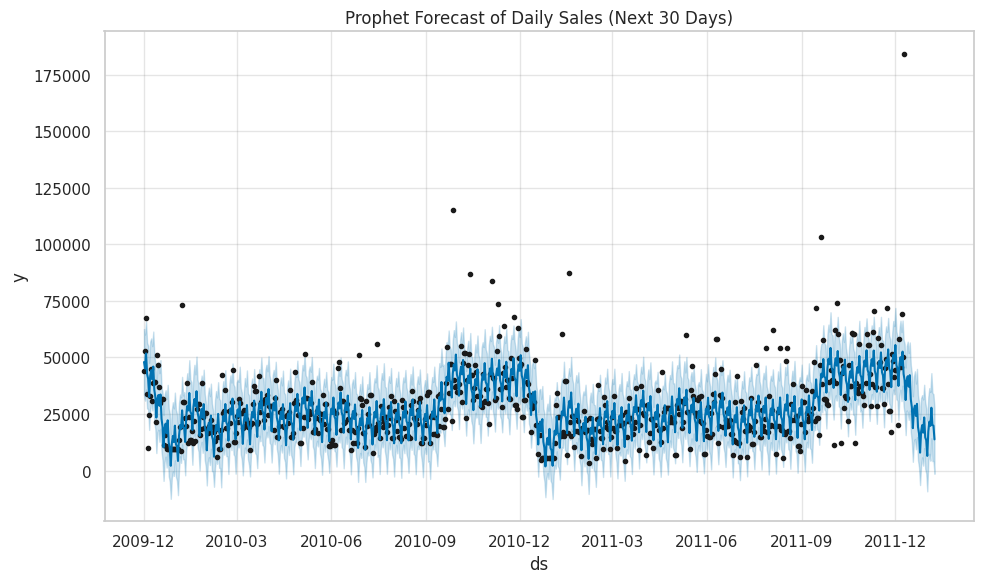

<Figure size 1200x600 with 0 Axes>

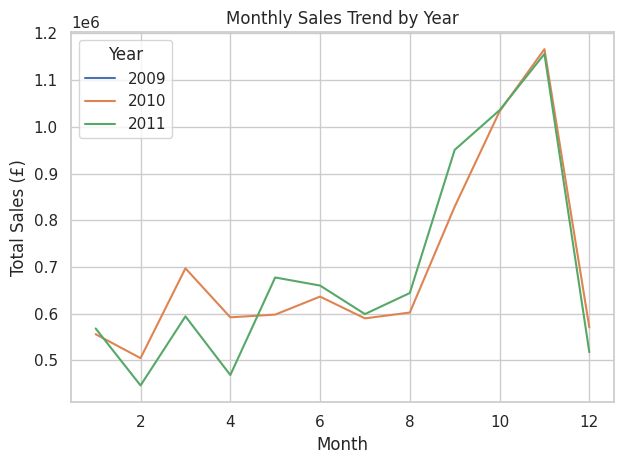

In [95]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Ensure datetime and create TotalPrice
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']

# Aggregate daily sales
df_daily_sales = df_clean.groupby(df_clean['InvoiceDate'].dt.date)['TotalPrice'].sum()
df_daily_sales = df_daily_sales.to_frame()
df_daily_sales.index = pd.to_datetime(df_daily_sales.index)
df_daily_sales = df_daily_sales.asfreq('D')  # <--- Ensures date index has frequency

# --- Plot daily sales ---
plt.figure(figsize=(12, 6))
df_daily_sales['TotalPrice'].plot(title='Daily Sales', xlabel='Date', ylabel='Total Sales (£)', fontsize=12)
plt.tight_layout()
plt.show()

# Forward-fill missing values to avoid NaNs
df_daily_sales['TotalPrice'] = df_daily_sales['TotalPrice'].fillna(method='ffill')

# Now apply seasonal decomposition
decomposition = seasonal_decompose(df_daily_sales['TotalPrice'], model='multiplicative', period=30)
decomposition.plot()
plt.tight_layout()
plt.show()

# --- ARIMA Forecast ---
model = ARIMA(df_daily_sales['TotalPrice'], order=(5, 1, 0))
model_fit = model.fit()

# Forecast next 30 days
forecast = model_fit.forecast(steps=30)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df_daily_sales.index, df_daily_sales['TotalPrice'], label='Historical Sales')
plt.plot(pd.date_range(df_daily_sales.index[-1] + pd.Timedelta(days=1), periods=30, freq='D'), forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast of Daily Sales (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Sales (£)')
plt.legend()
plt.tight_layout()
plt.show()

from prophet import Prophet  # use 'prophet' not 'fbprophet' in latest versions

# Prepare data for Prophet
df_prophet = df_daily_sales.reset_index()
df_prophet = df_prophet.rename(columns={'InvoiceDate': 'ds', 'TotalPrice': 'y'})
df_prophet = df_prophet[['ds', 'y']].dropna()

# Prophet model
prophet_model = Prophet(daily_seasonality=True)
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
prophet_model.fit(df_prophet)

# Future dates
future = prophet_model.make_future_dataframe(periods=30)

# Forecast
forecast_prophet = prophet_model.predict(future)

# Plot forecast
fig = prophet_model.plot(forecast_prophet)
plt.title('Prophet Forecast of Daily Sales (Next 30 Days)')
plt.tight_layout()
plt.show()


# Plot
fig = prophet_model.plot(forecast_prophet)
plt.title('Prophet Forecast of Daily Sales (Next 30 Days)')
plt.tight_layout()
plt.show()

# --- Monthly Seasonality Visualization ---
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
monthly_sales = df_clean.groupby(['Year', 'Month'])['TotalPrice'].sum().unstack()

# Plot seasonality
plt.figure(figsize=(12, 6))
monthly_sales.T.plot(title='Monthly Sales Trend by Year', xlabel='Month', ylabel='Total Sales (£)')
plt.tight_layout()
plt.show()
